## Description

**Dataset**

Each example is a random pair of MNIST digits placed at random positions within a large black image, with the target label of the sum of the MNIST digits.

**Model**

A CNN over the entire image. Serves as baseline where entire image is visible.



## Install

In [0]:
!pip3 install torch torchvision numpy

## Imports

In [0]:
from matplotlib import pyplot as plt
import numpy as np

import torch as th
from torch import nn
import torchvision
from torchvision import transforms

%load_ext autoreload
%autoreload 2

def show_image(image):
  image = image.squeeze()
  plt.imshow(image, cmap='gray')
  plt.axis('off')

## Config

In [0]:
debug = False
device = th.device('cuda' if th.cuda.is_available() and not debug else 'cpu')
print(f'Using {device}')

# Synthetic dataset
width = 128
height = 128
num_images = 50000
num_images_test = 10000
tiles_per_image = 2
num_classes = 1 + 9 * tiles_per_image  # [0, ..., 9 * n]

num_epochs = 10
batch_size = 32
learning_rate = 0.001

Using cuda


## Dataset: MNIST Pair Sum 

In [0]:
from rl.core.envs import synthetic_dataset

train_dataset = synthetic_dataset.MnistSyntheticDataset(
    width=width, height=height, num_images=num_images,
    tiles_per_image=tiles_per_image, train=True)

train_loader = th.utils.data.DataLoader(
    dataset=train_dataset, batch_size= batch_size, shuffle=True)

test_dataset = synthetic_dataset.MnistSyntheticDataset(
    width=width, height=height, num_images=num_images_test,
    tiles_per_image=tiles_per_image, train=False)

test_loader = th.utils.data.DataLoader(
    dataset=test_dataset, batch_size= batch_size, shuffle=False)

## Model (CNN)

In [0]:
# Convolutional neural network.
class CNN(nn.Module):
  def __init__(self, num_outputs):
    super().__init__()
    self.convs = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2),
        nn.BatchNorm2d(16),
        nn.ReLU(),

        nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        
        nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
         
        nn.Conv2d(256, 256, kernel_size=5, stride=2, padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
    )
    self.pooling = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(256, num_outputs)
    
  def forward(self, x):
    out = self.convs(x)
    out = self.pooling(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    return out

In [0]:
model = CNN(num_classes).to(device)

## Train

In [0]:
from rl.core.algs import plotter

plotter = plotter.Plotter(log_dir='/tmp/tensorboard/synthetic_mnist_conv')

# Loss and optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)


num_steps = len(train_loader)
for epoch in range(num_epochs):
  for step, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device, dtype=th.long)

    # Forward
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 100 == 0:
      plotter.add_data('loss', epoch * num_steps + step,
                       loss.detach().cpu().numpy())

  print(f'Epoch [{epoch+1}/{num_epochs}], '
        f'Loss: {loss.item():.4}')  

Epoch [1/10], Loss: 1.685
Epoch [2/10], Loss: 1.165
Epoch [3/10], Loss: 0.3682
Epoch [4/10], Loss: 0.1682
Epoch [5/10], Loss: 0.1132
Epoch [6/10], Loss: 0.261
Epoch [7/10], Loss: 0.2014
Epoch [8/10], Loss: 0.1363
Epoch [9/10], Loss: 0.0162
Epoch [10/10], Loss: 0.02899


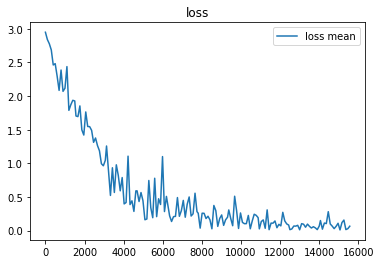

In [0]:
plotter.line_plot()

## Test

In [0]:
with th.no_grad():
  correct, total = 0, 0
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device, dtype=th.long)
    outputs = model(images)
    _, predicted = th.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  accuracy = correct / total
  print(f'Accuracy of model on {total} test images: {100 * accuracy:0.2f}%')

Accuracy of model on 10000 test images: 92.25%


In [0]:
with th.no_grad():
  correct, total = 0, 0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device, dtype=th.long)
    outputs = model(images)
    _, predicted = th.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  accuracy = correct / total
  print(f'Accuracy of model on {total} train images: {100 * accuracy:0.2f}%')

Accuracy of model on 50000 train images: 98.05%


## Visualize

In [0]:
with th.no_grad():
  images, labels = next(iter(test_loader))
  images, labels = images.to(device), labels.to(device, dtype=th.long)
  preds = model(images)

tensor(7, device='cuda:0') tensor(7, device='cuda:0')
tensor([-50.6274, -18.6521, -12.5974, -21.6094, -18.7693, -11.1372, -10.9024,
          7.5386,  -5.2741,  -9.0151,  -7.0277, -16.5308, -12.8229,  -7.0105,
        -18.2101, -12.1193, -27.3355, -40.6546, -49.5329], device='cuda:0')


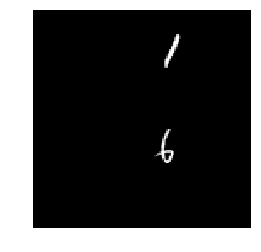

In [0]:
show_image(images[0].cpu())
print(labels[0], th.argmax(preds[0]))
print(preds[0])

tensor(11, device='cuda:0') tensor(11, device='cuda:0')
tensor([-50.4466, -33.7269, -22.2225, -18.6116, -12.6805, -11.0856,  -6.9643,
        -11.1906, -13.8418, -11.0735,  -1.8567,  13.2946,  -7.8718, -10.6005,
        -20.8640, -17.4408, -10.9239, -11.3939, -16.3599], device='cuda:0')


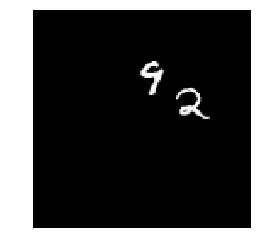

In [0]:
show_image(images[-1].cpu())
print(labels[-1], th.argmax(preds[-1]))
print(preds[-1])

## Save model

In [0]:
th.save(model.state_dict(), '/tmp/synthetic_mnist_conv.ckpt')